In [4]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [7]:
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from src.model import get_model
from src.net import ObjSurrogate, Fixer
from src.utils import load_from_wandb
from src.dataset import EarlyFixingDataset

In [9]:
with open('../ef_objs.pkl', 'rb') as f:
    ef_objs = pickle.load(f)

ds = EarlyFixingDataset(ef_objs)
ds[0]

((array([[ 5.43380e+02,  9.54310e+02,  1.03968e+03,  1.07540e+03,
           1.09698e+03,  1.11235e+03],
         [-1.00000e+00,  7.97540e+02,  9.11190e+02,  9.60910e+02,
           9.87640e+02,  1.00601e+03],
         [-1.00000e+00,  6.50800e+02,  7.84400e+02,  8.46670e+02,
           8.80830e+02,  9.01870e+02],
         [-1.00000e+00,  5.14720e+02,  6.59880e+02,  7.31980e+02,
           7.73510e+02,  7.98180e+02],
         [-1.00000e+00,  3.48110e+02,  5.40280e+02,  6.18140e+02,
           6.65130e+02,  6.94060e+02],
         [-1.00000e+00,  1.55440e+02,  4.29100e+02,  5.07960e+02,
           5.57600e+02,  5.89250e+02]]),
  0.54,
  112.1),
 (array([1., 0., 0., 0., 0.]), array([0., 0., 0., 0., 1.])))

In [14]:
surrogate = load_from_wandb(ObjSurrogate(add_dropout=True), 'ay9pgcy0', 'gef-fs')

net = Fixer()

q_liq_fun, bsw, gor = ds[0][0]

q_liq_fun = torch.Tensor(q_liq_fun).unsqueeze(0)
bsw = torch.Tensor([bsw])
gor = torch.Tensor([gor])

logit = net(q_liq_fun, bsw, gor)

torch.softmax(logit, -1).shape

torch.Size([1, 2, 9])

In [19]:
gor.shape

torch.Size([1, 1])

In [46]:
X = list()
y = list()
for n in ef_objs.keys():
    for c1, c2, gl1, gl2 in ef_objs[n].keys():
        c_pair = (c1, c2)
        gl_pair = (gl1, gl2)

        c_mbd, gl_mbd = encode_fixing(c_pair, gl_pair, n)
        # c_mbd, gl_mbd = np.array(c_pair), np.array(gl_pair)

        X.append((n, c_mbd, gl_mbd))
        y.append(ef_objs[n][c1, c2, gl1, gl2])

In [79]:
c_ = np.pad(c_mbd, (0,1))
c_ += np.roll(c_, 1)
c_

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.])

In [47]:
well, c_mbd, gl_mbd = X[0]

model = get_model([well,], avoid_infeasible=False)

A = model.getA().toarray()
b = np.array(model.getAttr('rhs'))

A = torch.from_numpy(A).unsqueeze(0)
b = torch.from_numpy(b).unsqueeze(0)
z_c = torch.from_numpy(c_mbd).unsqueeze(0)
z_gl = torch.from_numpy(gl_mbd).unsqueeze(0)

x = torch.hstack([A.flatten(1), b, z_c, z_gl])
x.shape

Set parameter IntFeasTol to value 1e-09


torch.Size([1, 4472])

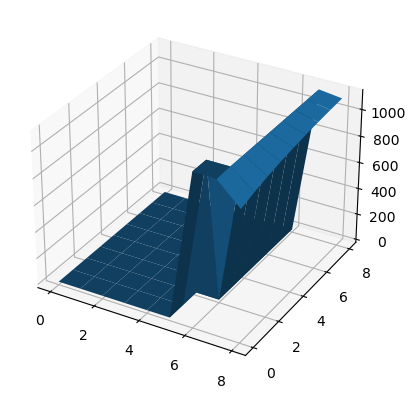

In [48]:
C = np.arange(len(c_mbd))
GL = np.arange(len(gl_mbd))

C, GL = np.meshgrid(C, GL)

Obj = -1 * np.ones(C.shape)
Obj

for (_, c_mbd, gl_mbd), obj in zip(X, y):
    Obj[c_mbd.argmax(), gl_mbd.argmax()] = obj

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(GL, C, Obj)
plt.show()

In [50]:
Obj.shape

(9, 9)

In [55]:
81 / (Obj > 0).sum()

4.05

In [20]:
from src.wells import *
from src.model import get_C_GL

# Insere valor -1 nos pontos espúrios (chaves faltantes) das curvas de produção
for n in Q_LIQ_N_FUN.keys():
    C, GL = get_C_GL(n)
    expected_keys = [(c, gl) for c in C for gl in GL]
    for key in expected_keys:
        if key not in Q_LIQ_N_FUN[n]:
            Q_LIQ_N_FUN[n][key] = -1

10
10
10


In [31]:
ds = WellObjDataset(ef_objs)
(C, GL, q_liq_fun, bsw, gor, c_mbd, gl_mbd), y = ds[-1]

q_liq_fun_flat = q_liq_fun.flatten()

C = torch.from_numpy(C).unsqueeze(0)
GL = torch.from_numpy(GL).unsqueeze(0)
q_liq_fun_flat = torch.from_numpy(q_liq_fun_flat).unsqueeze(0)
bsw = torch.Tensor([bsw,]).unsqueeze(0)
gor = torch.Tensor([gor,]).unsqueeze(0)
z_c = torch.from_numpy(c_mbd).unsqueeze(0)
z_gl = torch.from_numpy(gl_mbd).unsqueeze(0)

x = torch.hstack([C, GL, q_liq_fun_flat, bsw, gor, z_c, z_gl])
x.shape

torch.Size([1, 126])

In [36]:
ef_objs_train = ef_objs.copy()
ef_objs_train.pop('JUB-55', None)
ef_objs_train.pop('JUB-58', None)

ds = WellObjDataset(ef_objs_train)

n_pos = 0
for _, y in ds:
    if y > 0:
        n_pos += 1
n_pos

40

# Train

In [49]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

net = ObjSurrogate(layers=[1000, 100, 10, 1]).double().to(device)

opt = torch.optim.Adam(net.parameters(), lr=.01)
loss_fun = torch.nn.MSELoss()

ef_objs_train = ef_objs.copy()
ef_objs_train.pop('JUB-58', None)
ef_objs_train.pop('JUB-55', None)

ds_train = EarlyFixingDataset(ef_objs_train)

ef_objs_test = ef_objs.copy()
ef_objs_test.pop('JUB-58', None)
ef_objs_test.pop('JUB-55', None)

ds_test = EarlyFixingDataset(ef_objs_test)

dl_train = DataLoader(ds_train, 2**4, shuffle=True)
dl_test = DataLoader(ds_test, 2**4)

train_losses = list()
test_losses = list()
for _ in tqdm(list(range(10000))):
    net.train()
    train_loss = 0
    for (A, b, z_c, z_gl), y in dl_train:

        y_hat = net(A.to(device), b.to(device), z_c.to(device), z_gl.to(device))

        loss = loss_fun(y_hat, y.unsqueeze(-1).double().to(device))

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += loss.item() / len(y)
        break
    train_losses.append(train_loss / len(dl_train))

    net.eval()
    test_loss = 0
    for (A, b, z_c, z_gl), y in dl_test:
        with torch.no_grad():
            y_hat = net(A.to(device), b.to(device), z_c.to(device), z_gl.to(device))

            loss = loss_fun(y_hat, y.unsqueeze(-1).double().to(device))

        test_loss += loss.item() / len(y)
    test_losses.append(test_loss / len(dl_test))

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.title('Loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.yscale('log')
plt.show()

Set parameter IntFeasTol to value 1e-09
Set parameter IntFeasTol to value 1e-09


  0%|          | 0/10000 [00:00<?, ?it/s]

TypeError: ObjSurrogate.forward() missing 3 required positional arguments: 'gor', 'z_c', and 'z_gl'

In [85]:
(A, b, z_c, z_gl), y = next(iter(dl_train))

net(A.to(device), b.to(device), z_c.to(device), z_gl.to(device))

tensor([[-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846]], device='cuda:0', dtype=torch.float64,
       grad_fn=<AddmmBackward0>)

In [ ]:
import torch.nn as nn

ae = nn.Sequential(
    # Encoder
    nn.Linear(4458, 1000),
    nn.ReLU(),
    nn.Linear(1000, 1000),
    nn.ReLU(),
    nn.Linear(1000, 100),
    nn.ReLU(),
    # Decoder
    nn.Linear(100, 1000),
    nn.ReLU(),
    nn.Linear(1000, 1000),
    nn.ReLU(),
    nn.Linear(1000, 4458),
).double()

x_hat = ae(x)

x_hat

tensor([[-225.9397,  547.1585,   78.6895,  ..., -120.5317, -549.2405,
          277.7825]], dtype=torch.float64, grad_fn=<AddmmBackward0>)

## Trained model

In [61]:
from src.utils import load_from_wandb
from src.trainer import ObjectiveSurrogateTrainer

net = ObjSurrogate(layers=[50, 20, 10, 1]).double()
net = load_from_wandb(net, '6z9f5sud', 'gef-fs').to(device)

trainer = ObjectiveSurrogateTrainer(net, '../ef_objs.pkl')
trainer.prepare_data()
dl_train, dl_test = trainer.data, trainer.val_data

(C, GL, q_liq_fun, bsw, gor, z_c, z_gl), y = next(iter(dl_train))
C = C.to(device)
GL = GL.to(device)
q_liq_fun = q_liq_fun.to(device)
bsw = bsw.to(device)
gor = gor.to(device)
z_c = z_c.to(device)
z_gl = z_gl.to(device)

y

tensor([-1.0000e+00, -1.0000e+00, -1.0000e+00,  1.0052e+03, -1.0000e+00,
        -1.0000e+00,  1.0530e+03, -1.0000e+00, -1.0000e+00,  9.5818e+02,
        -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00,  1.0226e+03, -1.0000e+00, -1.0000e+00,
         1.0530e+03, -1.0000e+00,  1.0530e+03, -1.0000e+00, -1.0000e+00,
        -1.0000e+00,  9.8902e+02, -1.0000e+00,  9.7007e+02, -1.0000e+00,
         9.9657e+02, -1.0000e+00,  1.0530e+03, -1.0000e+00, -1.0000e+00,
         1.0530e+03, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,  1.0493e+03,
        -1.0000e+00,  9.0781e+02,  1.0530e+03, -1.0000e+00, -1.0000e+00,
         8.8357e+02, -1.0000e+00, -1.0000e+00, -1.0000e+00,  9.8026e+02,
         1.0530e+03, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
         1.0371e+03, -1.0000e+00, -1.0000e+00, -1.0000e+00])

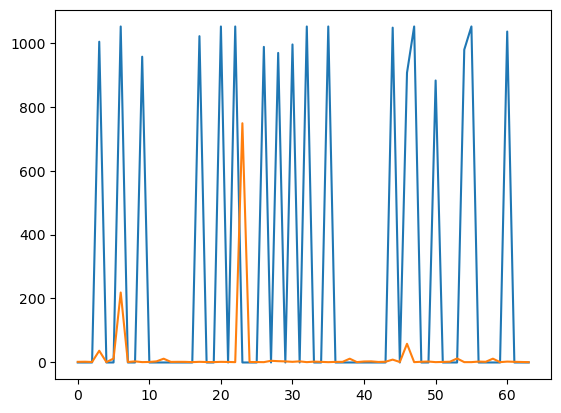

In [72]:
with torch.no_grad():
    y_hat = net(C, GL, q_liq_fun, bsw, gor, z_c, z_gl)

plt.plot(y.cpu())
plt.plot((y.cpu() - y_hat.cpu().squeeze()).abs())
plt.show()